In [1]:

from matplotlib import pyplot as plt
import numpy as np
from RL.TCell import TCell_Threshold
import pandas as pd
from RL.APC import StochasticAPC


\frac{# } Re{producing the results of Baumgart et al}.
We opted not to use the metaphorical terminology of the search theory of Baumgart et al. and rather stick to the target terminology:
Instead of a `Haystack`, we search a `Body`, which instead of containing multiple `Haybales` contains multiple `APCs`, which are either `positive`, making the body `infected` or `negative`, making the body `healthy`.

M := number of positive APCs

N := total number of APCs

$p = M/N :=$ probability of 1 APC to be positive, expressed as an average over all APCs

n := number of checked APCs

k := number of APCs truly identified as positive

$p   =  \frac{M }{N}$

### Global evaluation
When performing a test on multiple APCs, with these metrics you evaluate a T-Cells performance across the whole population to determine how well it can identify a `infected` body.

$TPR =  \frac{TP}{(TP + FN)}$

$FPR =  \frac{FP}{(TN + FP)}$

$TNR =  \frac{TN}{(TN + FP)}$

$FNR =  \frac{FN}{(FN + TP)}$

### Local evaluation
When performing a test on a single APC, with these metrics you evaluate a T-Cells performance on a single case to determine how well it can identify a `positive` APC. While this is not measurable (a population of 1 has either k = 1 for a tp or 0 else), it is controllable via the agent (TCell) policy.

$tpr =  \frac{tp}{(tp + fn)}$

$fpr =  \frac{fp}{(tn + fp)}$

$tnr =  \frac{tn}{(tn + fp)}$

$fnr =  \frac{fn}{(fn + tp)}$






# Setup
## Environment: APC
Each APC is a reinforcement learning environment. It carries the attribute `isPositive`, which is either `True` or `False`. This is invisible to the agent.
### States: S
Each state is an array of three values:
1. the timestep `t`, natural numbers
2. the perceived probability of the APC being positive `q` $\in [0, 1]$. This starts at `0.5` and gets nudged in either direction toward 0 or 1, depending on the attribute `isPositive`.
3. `1` if this state is a terminal state, `0` at the start of an episode and made positive by the agent

### Actions: A
- `stay`: advance to the next timestep without making a decision
- `positive`: classify the APC to be `positive`
- `negative`: classify the APC to be `negative`

### Rewards: R
The values of the large rewards and penalties are subject to experimentation, as they strongly influence the agent's behaviour.
- `stay`: `-1`, penalty for waiting, encourages making a decision
- `positive`:
    - `tp`: some large reward (e.g. `100`)
    - `fp`: some large penalty (e.g. `-100`)
- `negative`: classify the APC to be `negative`
    - `tn`: some large reward (e.g. `100`)
    - `fn`: some large penalty (e.g. `-100`)

## T-Cell: Agent
The agent for the environments is a TCell.
It has a policy $\pi: S X A \rightarrow \mathbb{R} \in [0,1]$

Since the state-space is continuous, its policy is not tabular but rather a function, which can take many forms. For this purpose we design a `Policy` class, which is flexible and can, for example, be a linear function or a Neural Network.


APC is _negative_

APCThresholdPolicy threshold=0.95
Starting episode:
State t=0, q=0.5, stop=False
a_0: stay

State t=1, q=0.5, stop=False
a_1: stay

State t=2, q=0.3333, stop=False
a_2: stay

State t=3, q=0.25, stop=False
a_3: stay

State t=4, q=0.2, stop=False
a_4: stay

State t=5, q=0.1667, stop=False
a_5: stay

State t=6, q=0.1429, stop=False
a_6: stay

State t=7, q=0.125, stop=False
a_7: stay

State t=8, q=0.1111, stop=False
a_8: stay

State t=9, q=0.1, stop=False
a_9: stay

State t=10, q=0.0909, stop=False
a_10: stay

State t=11, q=0.0833, stop=False
a_11: stay

State t=12, q=0.0769, stop=False
a_12: stay

State t=13, q=0.0714, stop=False
a_13: stay

State t=14, q=0.0667, stop=False
a_14: stay

State t=15, q=0.0625, stop=False
a_15: stay

State t=16, q=0.0588, stop=False
a_16: stay

State t=17, q=0.0556, stop=False
a_17: stay

State t=18, q=0.0526, stop=False
a_18: stay

State t=19, q=0.05, stop=False
a_19: stay

State t=20, q=0.0476, stop=False
a_20: negative

Finished episode 

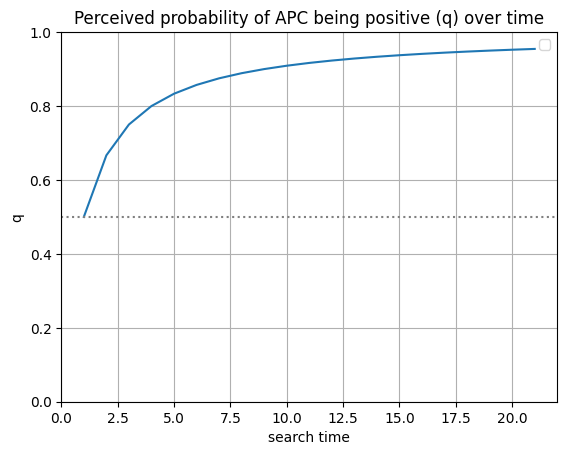

In [7]:
# play a single episode with a TCell
# use a TCell_Threshold
# this TCell variant uses a simple policy that makes a decision solely based on q
# if q is higher than the treshold or the final timestep is reached and q>0.5, it makes a positive classification
# if q is lower than 1-threshold or the final timestep is reached and q<0.5, it makes a negative classification
# otherwise it waits
# if you don't change the threshold/policy, every episode will converge at the same time

# StochasticAPC will pick a random value for isPositive, but you can also set it manually
env = StochasticAPC()
print(f"APC is _{'positive' if env.isPositive else 'negative'}_\n")
agent = TCell_Threshold(env, threshold=.95)
print(agent.policy)
# agent.policy.plot(agent)
R, t, transitions = agent.episode(verbose=True)
final_action = transitions[-1][1]
final_reward = transitions[-1][2]
agent.plot_transitions(transitions)


Baumgart et al. display a plot that shows the development of the global TPR as the number of checked APCs increases, for different probabilities of harmfulness. Here we recreate this plot using our environments


In [3]:


def test_TCell_Threshold(n=1000):
    # test many different TCell_Treshold instances with
    # varying thresholds
    # plot their results: FPR vs treshold
    env = StochasticAPC()
    results = []

    num_steps = 100  # number of steps
    for thresh in np.linspace(0.5, 1.0, num_steps):
        # reset the env
        env.reset()
        # make 100 episodes per each of the 100 different treshold levels
        agent = TCell_Threshold(env, T=100, threshold=thresh)
        for j in range(n):
            R, t, transitions = agent.episode(epsilon=0.1, verbose=False)
            final_action = transitions[-1][1]
            final_reward = transitions[-1][2]
            result = env.eval_action_reward(final_action, final_reward)
            results.append({"result":result, "t":t})

    df = pd.DataFrame(results)
    df = df.groupby("t")["result"].value_counts().unstack(fill_value=0).reset_index()
    df["TP"] = df.get("TP", 0)
    df["FP"] = df.get("FP", 0)
    df["TN"] = df.get("TN", 0)
    df["FN"] = df.get("FN", 0)
    print(df)

    # df["TPR"] = df["TP"] / (df["TP"] + df["FN"])
    # print(df)
    # df.plot.line("t", "TPR", xlabel="search time", title="Search time vs TPR")
    # plt.show()

test_TCell_Threshold()

result   t     TN     TP  FP  FN
0        2  15000  18000   0   0
1        3   6000  11000   0   0
2        4   6000   4000   0   0
3        5   4000   2000   0   0
4        6   1000   4000   0   0
5        7   1000   3000   0   0
6        8      0   2000   0   0
7        9   2000   1000   0   0
8       10      0   1000   0   0
9       11      0   2000   0   0
10      12   1000      0   0   0
11      13   1000      0   0   0
12      14   1000      0   0   0
13      15   1000      0   0   0
14      16   1000      0   0   0
15      18   1000      0   0   0
16      19      0   1000   0   0
17      22      0   1000   0   0
18      24      0   1000   0   0
19      28   1000      0   0   0
20      33      0   1000   0   0
21      39   1000      0   0   0
22      49   1000      0   0   0
23      66      0   1000   0   0
24      99   2000   1000   0   0
